<h1 align="center">Query SQL database with LangChain </h1>

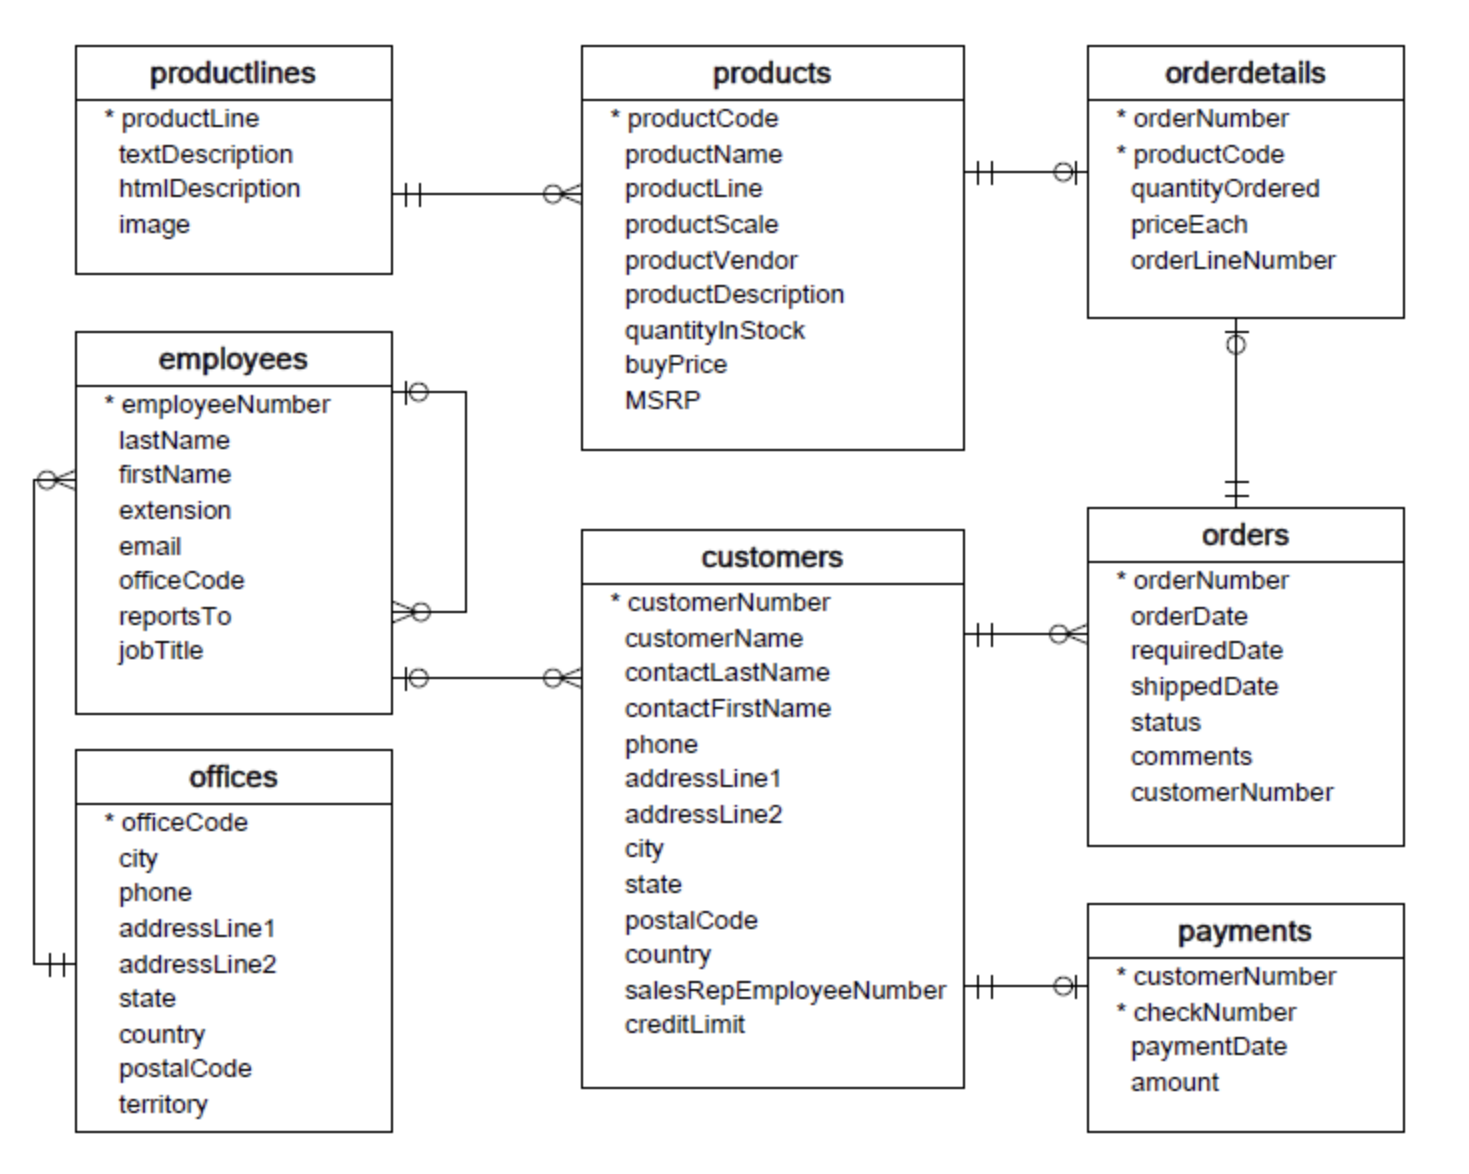

In [1]:
from langchain.agents import create_sql_agent
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain.sql_database import SQLDatabase
from langchain.llms.openai import OpenAI
from langchain.agents import AgentExecutor
from langchain.agents.agent_types import AgentType
from langchain.chat_models import ChatOpenAI

In [2]:
import openai
import os
from dotenv import load_dotenv

In [3]:
load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

In [4]:
def createDBConnectionString():
    db_user = os.getenv('DB_USERNAME')
    db_Password  = os.getenv('DB_PASSWORD')
    db_host = os.getenv('DB_HOST')
    db_name = os.getenv('DB_NAME')
    connectionString = f"mysql+pymysql://{db_user}:{db_Password}@{db_host}/{db_name}"
    return connectionString

In [5]:
def createAgentExecutor(openAI_model_name,mysql_connection_string):
    
    llm = ChatOpenAI(model_name= openAI_model_name )
    db = SQLDatabase.from_uri(mysql_connection_string)
    toolkit = SQLDatabaseToolkit(db=db, llm =llm)
    agent_executor = create_sql_agent(
                                    llm=llm,
                                    toolkit=toolkit,
                                    verbose=True,
                                    return_intermediate_steps=True)
    return agent_executor

In [7]:
openAI_model_name = "gpt-3.5-turbo"
mysql_connection_string = createDBConnectionString()
db_agent =  createAgentExecutor(openAI_model_name,mysql_connection_string)

In [12]:
db_agent.return_intermediate_steps

False

In [8]:
def fetchAnswer(db_agent,  question):
    agent_response = db_agent.run(question)
    return agent_response 

In [17]:
db_agent.run("Describe how the customers and orders tables are related")




> Entering new AgentExecutor chain...
Action: list_tables_sql_db
Action Input: ""
Observation: payments, customers, productlines, employees, products, orderdetails, orders, offices
Thought:The relevant tables are "customers" and "orders". I should query the schema of these tables to see how they are related.
Action: schema_sql_db
Action Input: "customers, orders"
Observation: 
CREATE TABLE customers (
	`customerNumber` INTEGER NOT NULL, 
	`customerName` VARCHAR(50) NOT NULL, 
	`contactLastName` VARCHAR(50) NOT NULL, 
	`contactFirstName` VARCHAR(50) NOT NULL, 
	phone VARCHAR(50) NOT NULL, 
	`addressLine1` VARCHAR(50) NOT NULL, 
	`addressLine2` VARCHAR(50), 
	city VARCHAR(50) NOT NULL, 
	state VARCHAR(50), 
	`postalCode` VARCHAR(15), 
	country VARCHAR(50) NOT NULL, 
	`salesRepEmployeeNumber` INTEGER, 
	`creditLimit` DECIMAL(10, 2), 
	PRIMARY KEY (`customerNumber`), 
	CONSTRAINT customers_ibfk_1 FOREIGN KEY(`salesRepEmployeeNumber`) REFERENCES employees (`employeeNumber`)
)DEFAULT CHARS

'The customers and orders tables are related through the customerNumber column.'

In [18]:
db_agent.run("Find the email id of the salesRepEmployeeNumber for customer number 124")




> Entering new AgentExecutor chain...
Action: list_tables_sql_db
Action Input: ""
Observation: payments, customers, productlines, employees, products, orderdetails, orders, offices
Thought:I can query the 'customers' and 'employees' tables to find the email id of the salesRepEmployeeNumber for customer number 124.
Action: schema_sql_db
Action Input: "customers, employees"
Observation: 
CREATE TABLE employees (
	`employeeNumber` INTEGER NOT NULL, 
	`lastName` VARCHAR(50) NOT NULL, 
	`firstName` VARCHAR(50) NOT NULL, 
	extension VARCHAR(10) NOT NULL, 
	email VARCHAR(100) NOT NULL, 
	`officeCode` VARCHAR(10) NOT NULL, 
	`reportsTo` INTEGER, 
	`jobTitle` VARCHAR(50) NOT NULL, 
	PRIMARY KEY (`employeeNumber`), 
	CONSTRAINT employees_ibfk_1 FOREIGN KEY(`reportsTo`) REFERENCES employees (`employeeNumber`), 
	CONSTRAINT employees_ibfk_2 FOREIGN KEY(`officeCode`) REFERENCES offices (`officeCode`)
)DEFAULT CHARSET=latin1 ENGINE=InnoDB

/*
3 rows from employees table:
employeeNumber	lastName	fi

'ljennings@classicmodelcars.com'

In [44]:
question = "find customerName for orderNumber 10100"
response = db_agent.run(question)




> Entering new AgentExecutor chain...
Action: list_tables_sql_db, 
Action Input: ""
Observation: list_tables_sql_db, is not a valid tool, try another one.
Thought:I should try a different tool to get the list of tables in the database.
Action: schema_sql_db
Action Input: 'customers, orders'
Observation: Error: table_names {"'customers", "orders'"} not found in database
Thought:I need to use the correct format for the input of the schema_sql_db tool. I need to remove the single quotes and separate the table names with commas.
Action: schema_sql_db
Action Input: customers, orders
Observation: 
CREATE TABLE customers (
	`customerNumber` INTEGER NOT NULL, 
	`customerName` VARCHAR(50) NOT NULL, 
	`contactLastName` VARCHAR(50) NOT NULL, 
	`contactFirstName` VARCHAR(50) NOT NULL, 
	phone VARCHAR(50) NOT NULL, 
	`addressLine1` VARCHAR(50) NOT NULL, 
	`addressLine2` VARCHAR(50), 
	city VARCHAR(50) NOT NULL, 
	state VARCHAR(50), 
	`postalCode` VARCHAR(15), 
	country VARCHAR(50) NOT NULL, 
	`sa

In [45]:
db_agent.return_intermediate_steps

'Online Diecast Creations Co.'

In [9]:
question = "find customerName for orderNumber 10100"
response  = db_agent(question)



> Entering new AgentExecutor chain...
Action: list_tables_sql_db
Action Input: 
Observation: orderdetails, productlines, payments, products, orders, offices, customers, employees
Thought:I see that the relevant tables are orders and customers. I should query the schema of these tables to find the columns I need.
Action: schema_sql_db
Action Input: orders, customers
Observation: 
CREATE TABLE customers (
	`customerNumber` INTEGER NOT NULL, 
	`customerName` VARCHAR(50) NOT NULL, 
	`contactLastName` VARCHAR(50) NOT NULL, 
	`contactFirstName` VARCHAR(50) NOT NULL, 
	phone VARCHAR(50) NOT NULL, 
	`addressLine1` VARCHAR(50) NOT NULL, 
	`addressLine2` VARCHAR(50), 
	city VARCHAR(50) NOT NULL, 
	state VARCHAR(50), 
	`postalCode` VARCHAR(15), 
	country VARCHAR(50) NOT NULL, 
	`salesRepEmployeeNumber` INTEGER, 
	`creditLimit` DECIMAL(10, 2), 
	PRIMARY KEY (`customerNumber`), 
	CONSTRAINT customers_ibfk_1 FOREIGN KEY(`salesRepEmployeeNumber`) REFERENCES employees (`employeeNumber`)
)ENGINE=Inno

In [13]:
db_agent.return_intermediate_steps

False